
0. Download required libraries


In [1]:
!pip install torchvision
!pip install imbalanced-learn
!pip install pretrainedmodels
!pip install torchmetrics
!pip install tsaug

     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=7b4fe9398ba492320961ba99a3284cc52e3456640ab3f4952d2c76778eae7d78
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 276kB 13.2MB/s 


0. Import required libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random as rand
import os
import sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import math

#For model building
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torchmetrics import F1
from torch.autograd import Variable

print(sys.version)
print(torch.__version__)
print(sklearn.__version__)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
1.8.1+cu101
0.22.2.post1


1-0. Colab Mount (just for my case)

In [4]:
'''
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
'''

Mounted at /gdrive


#1. Prepare Data

In [5]:
#data_folder = '/gdrive/My Drive/Colab Notebooks/ECG/Data'
data_folder = './Data'
train_path = os.path.join(data_folder,'mitbih_train.csv')
df_train = pd.read_csv(train_path)

test_path = os.path.join(data_folder,'mitbih_test.csv')
df_test = pd.read_csv(test_path)

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

X_train_original = df_train.iloc[:,:-1]
Y_train_original = df_train.iloc[:,-1]

# Split train data into {train, validation} data 
X_train, X_val, Y_train, Y_val = train_test_split(X_train_original, Y_train_original, test_size = 0.25, stratify = Y_train_original, random_state = 0)

X_test = df_test.iloc[:,:-1]
Y_test = df_test.iloc[:,-1]

# Sort and reset index
X_train = X_train.sort_index()
X_val = X_val.sort_index()
Y_train = Y_train.sort_index()
Y_val = Y_val.sort_index()

X_train.index = range(len(X_train.index))
X_val.index = range(len(X_val.index))
Y_train.index = range(len(Y_train.index))
Y_val.index = range(len(Y_val.index))

# Print label distribution
print('Train Set, Label Distribution : \n', pd.Series(Y_train).value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Train Set, Label Distribution : 
 0.0    54352
4.0     4823
2.0     4341
1.0     1667
3.0      481
Name: 0.000000000000000000e+00.88, dtype: int64


#2. Augment Data

2-1. SMOTE


In [7]:
from imblearn.over_sampling import SMOTE
#Set k_neighbors to 3
smote = SMOTE(random_state=0, k_neighbors = 3)
X_train_smote, Y_train_smote = smote.fit_resample(X_train,Y_train)
print('Before Smote X shape : ', X_train.shape)
print('After Smote X shape  : ', X_train_smote.shape)
print('After Smote, Label Distribution : \n', pd.Series(Y_train_smote).value_counts())
print('=================================================')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Before Smote X shape :  (65664, 187)
After Smote X shape  :  (271760, 187)
After Smote, Label Distribution : 
 1.0    54352
3.0    54352
4.0    54352
2.0    54352
0.0    54352
dtype: int64


2-2. Adasyn

In [8]:
from imblearn.over_sampling import ADASYN
#Set n_neighbors to 3
ada = ADASYN(random_state=0, n_neighbors = 3)
X_train_ada, Y_train_ada = ada.fit_resample(X_train,Y_train)
print('Before Adasyn X shape : ', X_train.shape)
print('After Adasyn X shape  : ', X_train_ada.shape)
print('After Adasyn, Label Distribution : \n', pd.Series(Y_train_ada).value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Before Adasyn X shape :  (65664, 187)
After Adasyn X shape  :  (271750, 187)
After Adasyn, Label Distribution : 
 1.0    54443
0.0    54352
2.0    54326
3.0    54316
4.0    54313
dtype: int64


2-3. Time Series Augmentation (test and visualize)

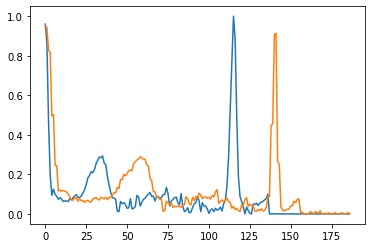

In [9]:
import tsaug
from tsaug import TimeWarp, AddNoise, Drift, Pool

#Test & Visualize time series augmentation (tsaug)
Test_Ser = np.asarray(X_train.iloc[0]).reshape(1,-1)
my_aug = (
    TimeWarp(n_speed_change = 2, max_speed_ratio = 2.5)+
    Drift(max_drift = 0.2, n_drift_points= 4) @ 0.3+
    Pool(size=2) @ 0.5+
    AddNoise(scale = rand.random()*0.03) @ 0.7 
)
y_new = my_aug.augment(Test_Ser)
y_new[y_new<0] = 0
y_new[y_new>1] = 1
plt.plot(Test_Ser[0])
plt.plot(y_new[0])

2-3. Time Series Augmentation

In [15]:
num_N, num_S, num_V, num_F, num_Q = pd.Series(Y_train).value_counts()[0], pd.Series(Y_train).value_counts()[1], pd.Series(Y_train).value_counts()[2], pd.Series(Y_train).value_counts()[3], pd.Series(Y_train).value_counts()[4]
num_N_test, num_S_test, num_V_test, num_F_test, num_Q_test = pd.Series(Y_test).value_counts()[0], pd.Series(Y_test).value_counts()[1], pd.Series(Y_test).value_counts()[2], pd.Series(Y_test).value_counts()[3], pd.Series(Y_test).value_counts()[4]
X_train_N, X_train_S, X_train_V, X_train_F, X_train_Q = X_train[0:num_N], X_train[num_N:num_N+num_S], X_train[num_N+num_S:num_N+num_S+num_V], \
                                                        X_train[num_N+num_S+num_V:num_N+num_S+num_V+num_F], X_train[num_N+num_S+num_V+num_F:num_N+num_S+num_V+num_F+num_Q]

df_col = []
for i in range(187):
    df_col.append(str(i))

def TSAug_Data(data, label, num_majority, num_data):
    original_data = np.asarray(data).reshape(num_data,-1)
    output_data = original_data
    mul_factor = int(np.round(num_majority/num_data)-1)
    augmentation = (
        TimeWarp(n_speed_change = 3, max_speed_ratio = 3)*mul_factor +
        Pool(size=2) @ 0.5 +
        Drift(max_drift = 0.2, n_drift_points= 4) @ 0.3 +
        AddNoise(scale = rand.random()*0.03) @ 0.7 
        )
    augmented_data = augmentation.augment(original_data)
    augmented_data[augmented_data<0] = 0
    augmented_data[augmented_data>1] = 1
    output_data = pd.DataFrame(np.concatenate((output_data,augmented_data)))
    output_data.columns = df_col
    
    output_label = [label]*len(output_data)
    print(len(output_data))
    return pd.DataFrame(output_data), pd.Series(output_label)

X_augmented_N, Y_augmented_N = TSAug_Data(X_train_N, 0, 4*num_N, num_N)
X_augmented_S, Y_augmented_S = TSAug_Data(X_train_S, 1, 4*num_N, num_S)
X_augmented_V, Y_augmented_V = TSAug_Data(X_train_V, 2, 4*num_N, num_V)
X_augmented_F, Y_augmented_F = TSAug_Data(X_train_F, 3, 4*num_N, num_F)
X_augmented_Q, Y_augmented_Q = TSAug_Data(X_train_Q, 4, 4*num_N, num_Q)

X_augmented = pd.concat([X_augmented_N, X_augmented_S, X_augmented_V, X_augmented_F, X_augmented_Q], ignore_index = True)
Y_augmented = pd.concat([Y_augmented_N, Y_augmented_S, Y_augmented_V, Y_augmented_F, Y_augmented_Q], ignore_index = True)
print(X_augmented)
print(Y_augmented)


217408
216710
217050
217412
217035
                0         1         2  ...       184       185  186
0        0.960114  0.863248  0.461538  ...  0.000000  0.000000  0.0
1        1.000000  0.659459  0.186486  ...  0.000000  0.000000  0.0
2        0.967136  1.000000  0.830986  ...  0.000000  0.000000  0.0
3        0.927461  1.000000  0.626943  ...  0.000000  0.000000  0.0
4        0.716814  0.539823  0.283186  ...  0.000000  0.000000  0.0
...           ...       ...       ...  ...       ...       ...  ...
1085610  0.901038  0.901038  0.895490  ...  0.000000  0.000000  0.0
1085611  0.906379  0.909385  0.874516  ...  0.012958  0.016214  0.0
1085612  0.907165  0.863660  0.832350  ...  0.005261  0.000000  0.0
1085613  0.901506  0.902101  0.900808  ...  0.000000  0.000000  0.0
1085614  0.901566  0.872347  0.811342  ...  0.000294  0.008854  0.0

[1085615 rows x 187 columns]
0          0
1          0
2          0
3          0
4          0
          ..
1085610    4
1085611    4
1085612    4
10

#3. Set Data Loader

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class MyDataset(Dataset):
    def __init__(self, Signal, Label):
        self.signal = Signal
        self.label = Label
    def __len__(self):
        return len(self.label)
    def __getitem__(self,idx):
        signal = self.signal.loc[idx]
        signal = signal.to_numpy().astype('float').reshape(-1,1)
        label = self.label.loc[idx]
        label = label.astype('int')
        sample = {'signal': signal, 'label': label}
        return sample

cuda:0


***** Choose augmentation!! (2nd line)

In [18]:
#Choose between ({X_train, X_train_smote, X_train_ada, X_augmented}, {Y_train, ...})
train_ds = MyDataset(Signal = pd.DataFrame(X_augmented), Label = pd.Series(Y_augmented))

val_ds = MyDataset(Signal = X_val, Label = Y_val)
test_ds = MyDataset(Signal = X_test, Label = Y_test)

bs = 256
train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = bs, shuffle = True)
test_loader = DataLoader(test_ds, batch_size = bs, shuffle = True)

#Generate RNN model

In [19]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])
        return out

In [22]:
def train(input_variable, target_variable, model, optimizer, criterion):
    
    optimizer.zero_grad()
    
    loss = 0
    input_variable = input_variable.view(-1, 187,1)
    model_output = model(input_variable)
    loss = criterion(model_output, target_variable)
    loss.backward()
    optimizer.step()

    return loss.data

def val(input_variable, target_variable, model, criterion):

    loss = 0
    input_variable = input_variable.view(-1, 187,1)
    model_output = model(input_variable)
    loss = criterion(model_output, target_variable)
    
    return loss.data
    
def test(input_variable, model):
    input_variable = input_variable.view(-1, 187,1)
    model_output = model(input_variable)
    top_n, top_i = model_output.data.topk(1)
    return torch.flatten(top_i)




def trainIters(model, epoch, learning_rate=1e-3):
    
    #model_path = '/gdrive/My Drive/Colab Notebooks/ECG/model_tsaug_exp1.pt'
    model_path = './Model/model.pt'
    n_epochs = epoch
    current_loss = 0
    all_losses = []
    val_losses = []
    acc_rate = []
    acc = 0
    val_loss_min = math.inf
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    weight  = torch.Tensor([0.1, 1, 0.3, 1, 0.1])
    #Choose between two (Either adjust weight or not)
    criterion = nn.CrossEntropyLoss().to(device)
    #criterion = nn.CrossEntropyLoss(weight = weight).to(device)

    for epoch in range(1, n_epochs+1):
        model.train()
        for batch_idx_train, batch_data in enumerate(train_loader):
            bs_train, _, _ = batch_data['signal'].shape
            signal, label = batch_data['signal'].type(torch.FloatTensor).view(bs_train,1,-1).to(device), batch_data['label'].type(torch.LongTensor).to(device)
            loss = train(signal, label, model, optimizer,  criterion)
            current_loss += loss

        model.eval()
        val_loss = 0
        for batch_idx_val, batch_data in enumerate(val_loader):
            bs_val, _, _ = batch_data['signal'].shape
            signal, label = batch_data['signal'].type(torch.FloatTensor).view(bs_val,1,-1).to(device), batch_data['label'].type(torch.LongTensor).to(device)
            loss = val(signal, label, model, criterion)
            val_loss += loss

        if val_loss < val_loss_min:
            val_loss_min = val_loss
            print("------------------Save------------------")
            torch.save(model,model_path)


        confusion = torch.zeros(5,5)
        pred = []
        true = []
        for batch_idx_test, batch_data in enumerate(test_loader):
            bs_test, _, _ = batch_data['signal'].shape
            signal, label = batch_data['signal'].type(torch.FloatTensor).view(bs_test,1,-1).to(device), torch.flatten(batch_data['label'].type(torch.LongTensor).to(device))
            guess = test(signal, model)
            
            #Build Confusion Matrix
            
            for i in range(len(guess)):
                pred.append(guess[i])
                true.append(label[i])
                confusion[guess[i]][label[i]] += 1
        
        #Calculate F1 score each epoch
        
        pred = torch.IntTensor(pred)
        true = torch.IntTensor(true)
        f1 = F1(num_classes = 5, average = 'macro')
        f1_score = f1(pred,true)

        #Calculate precision / recall / overall accuracy

        pre_N = (confusion[0][0])/((confusion[0][0]+confusion[0][1]+confusion[0][2]+confusion[0][3]+confusion[0][4]))
        pre_S = (confusion[1][1])/((confusion[1][0]+confusion[1][1]+confusion[1][2]+confusion[1][3]+confusion[1][4]))
        pre_V = (confusion[2][2])/((confusion[2][0]+confusion[2][1]+confusion[2][2]+confusion[2][3]+confusion[2][4]))
        pre_F = (confusion[3][3])/((confusion[3][0]+confusion[3][1]+confusion[3][2]+confusion[3][3]+confusion[3][4]))
        pre_Q = (confusion[4][4])/((confusion[4][0]+confusion[4][1]+confusion[4][2]+confusion[4][3]+confusion[4][4]))

        rec_N = (confusion[0][0])/((confusion[0][0]+confusion[1][0]+confusion[2][0]+confusion[3][0]+confusion[4][0]))
        rec_S = (confusion[1][1])/((confusion[0][1]+confusion[1][1]+confusion[2][1]+confusion[3][1]+confusion[4][1]))
        rec_V = (confusion[2][2])/((confusion[0][2]+confusion[1][2]+confusion[2][2]+confusion[3][2]+confusion[4][2]))
        rec_F = (confusion[3][3])/((confusion[0][3]+confusion[1][3]+confusion[2][3]+confusion[3][3]+confusion[4][3]))
        rec_Q = (confusion[4][4])/((confusion[0][4]+confusion[1][4]+confusion[2][4]+confusion[3][4]+confusion[4][4]))
        
        F1_N = 2*torch.divide(torch.multiply(pre_N,rec_N),torch.add(pre_N,rec_N))
        F1_S = 2*torch.divide(torch.multiply(pre_S,rec_S),torch.add(pre_S,rec_S))
        F1_V = 2*torch.divide(torch.multiply(pre_V,rec_V),torch.add(pre_V,rec_V))
        F1_F = 2*torch.divide(torch.multiply(pre_F,rec_F),torch.add(pre_F,rec_F))
        F1_Q = 2*torch.divide(torch.multiply(pre_Q,rec_Q),torch.add(pre_Q,rec_Q))

        acc = (confusion[0][0]+confusion[1][1]+confusion[2][2]+confusion[3][3]+confusion[4][4])/(batch_idx_test*bs)

        #record & print metrics (loss, accuracy)

        all_losses.append(current_loss / batch_idx_train)
        val_losses.append(val_loss / batch_idx_val)
        acc_rate.append(acc*100)
        print('Train Loss: %.4f, Val_Loss = %.4f' %(current_loss / batch_idx_train, val_loss / batch_idx_val))
        current_loss = 0
        print('Macro Average Test F1: %.2f%%' %(f1_score*100))
        print('''%d epoch: acc = %.2f%%, pre_N = %.2f%%, rec_N = %.2f%%, pre_S = %.2f%%, rec_S = %.2f%%, pre_V = %.2f%%,rec_V = %.2f%%, pre_F = %.2f%%, rec_F = %.2f%%, pre_Q = %.2f%%, rec_Q = %.2f%%
        F1_N: %.2f%%, F1_S = %.2f%%, F1_V = %.2f%%, F1_F = %.2f%%, F1_Q = %.2f%%'''
              %(epoch, acc*100, pre_N*100, rec_N*100, pre_S*100, rec_S*100, pre_V*100, rec_V*100, pre_F*100, rec_F*100, pre_Q*100, rec_Q*100, F1_N*100, F1_S*100, F1_V*100, F1_F*100, F1_Q*100))
        
    #plot final results    
    
    plt.figure()
    plt.plot(all_losses)
    plt.plot(val_losses)
    plt.title('loss')
    plt.figure()
    plt.plot(acc_rate)
    plt.title('acc')

    print(confusion)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    plt.show()

5. Execute training

In [ ]:
rnn = RNN(input_size = 1, hidden_size = 128, num_layers = 2, num_classes = 5)

cuda =  torch.cuda.is_available()

if torch.cuda.is_available():
    rnn = rnn.cuda()

trainIters(rnn, 200)

------------------Save------------------
Train Loss: 0.9079, Val_Loss = 0.2876
Macro Average Test F1: 73.33%
1 epoch: acc = 92.35%, pre_N = 98.68%, rec_N = 92.20%, pre_S = 38.40%, rec_S = 72.30%, pre_V = 71.39%,rec_V = 89.43%, pre_F = 31.90%, rec_F = 87.04%, pre_Q = 93.56%, rec_Q = 96.64%
        F1_N: 95.33%, F1_S = 50.16%, F1_V = 79.40%, F1_F = 46.69%, F1_Q = 95.07%
------------------Save------------------
Train Loss: 0.2628, Val_Loss = 0.1521
Macro Average Test F1: 80.48%
2 epoch: acc = 95.32%, pre_N = 99.11%, rec_N = 95.03%, pre_S = 42.94%, rec_S = 81.47%, pre_V = 87.87%,rec_V = 94.06%, pre_F = 49.25%, rec_F = 81.48%, pre_Q = 95.75%, rec_Q = 98.07%
        F1_N: 97.03%, F1_S = 56.24%, F1_V = 90.86%, F1_F = 61.40%, F1_Q = 96.90%
------------------Save------------------
Train Loss: 0.1607, Val_Loss = 0.1218
Macro Average Test F1: 82.18%
3 epoch: acc = 96.48%, pre_N = 99.27%, rec_N = 96.42%, pre_S = 56.46%, rec_S = 80.22%, pre_V = 89.82%,rec_V = 92.61%, pre_F = 42.69%, rec_F = 91.98%,